# 語音情感分析

http://mirlab.org/jang/books/audiosignalprocessing
https://musicinformationretrieval.com/index.html
https://github.com/PrudhviGNV/Speech-Emotion-Recognization


內核:affective_computing

## 基本原理

In [3]:
import numpy as np
import librosa
import librosa.display
import IPython
import glob
import os
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier 
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC 
import sklearn
import matplotlib.pyplot as plt
import pickle
import warnings
warnings.filterwarnings("ignore")

### 清音 vs. 浊音: Sunday的发音

In [4]:
audio_file = "./data/example/sunday.wav"
IPython.display.Audio(audio_file)

sunday


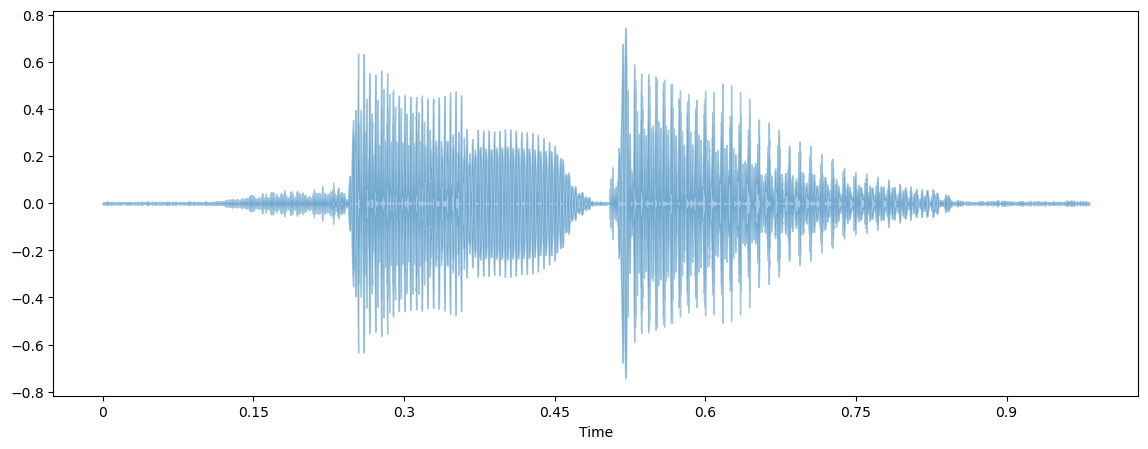

s


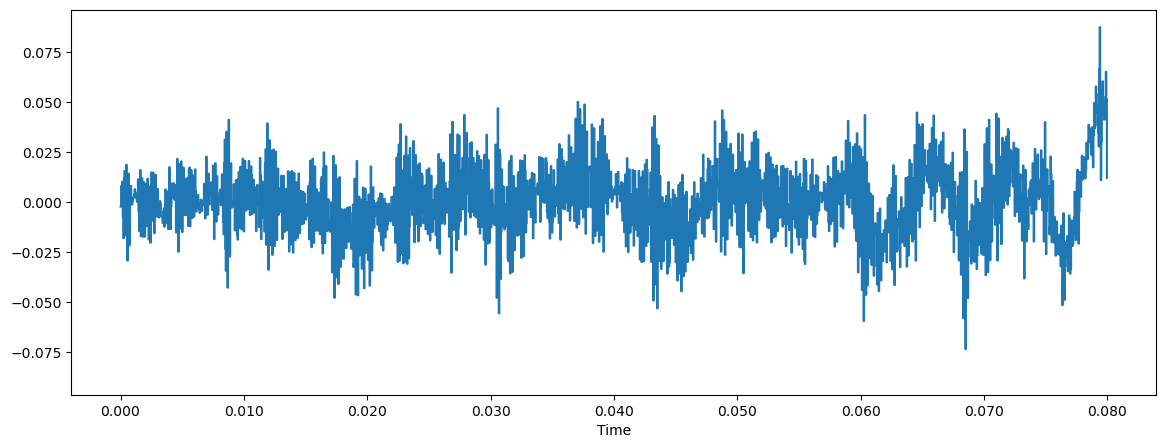

s vs ay


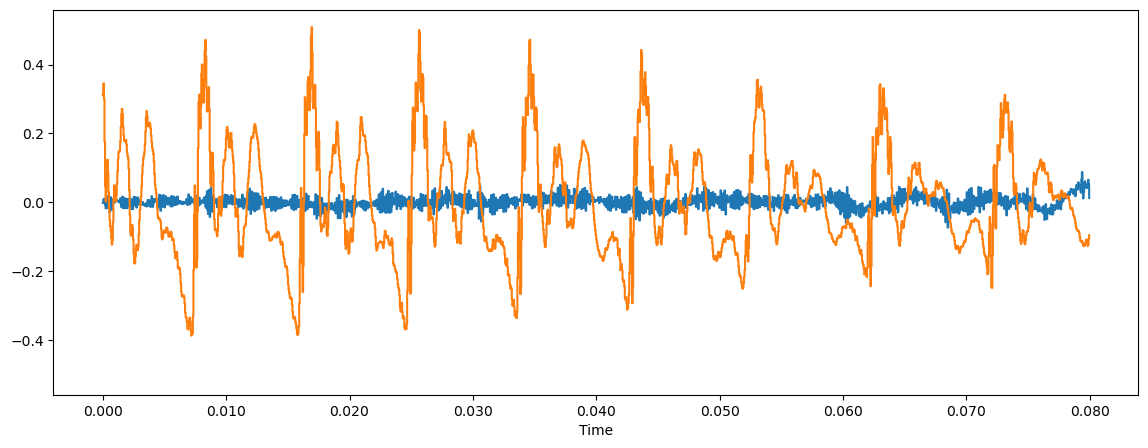

In [5]:
print("sunday")
plt.figure(figsize=(14, 5))
sample, sampling_rate = librosa.load(audio_file)
librosa.display.waveshow(sample, sr=sampling_rate, alpha=0.4)
plt.show()

# Zooming in
sample_s = sample[int(0.15*sampling_rate):int(0.23*sampling_rate)]
sample_ay = sample[int(0.6*sampling_rate):int(0.68*sampling_rate)]
print("s")
plt.figure(figsize=(14, 5))
librosa.display.waveshow(sample_s, sr=sampling_rate, alpha=1)
plt.show()
print("s vs ay")
plt.figure(figsize=(14, 5))
librosa.display.waveshow(sample_s, sr=sampling_rate, alpha=1)
librosa.display.waveshow(sample_ay, sr=sampling_rate, alpha=1)
plt.show()


## 常用特征
### 长度音量
#### “计算响度” vs.“感知响度”

In [33]:
audio_file = "./data/example/aeiou.wav"
sample_x, sampling_rate = librosa.load(audio_file, sr=44100)
librosa.get_duration(sample_x, sampling_rate)

5.337006802721088

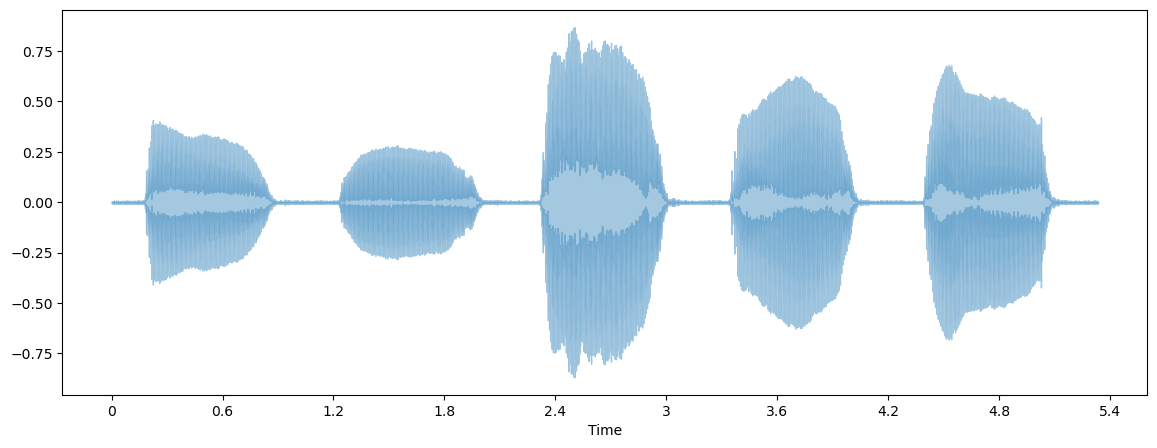

In [7]:
plt.figure(figsize=(14, 5))
librosa.display.waveshow(sample_x, sr=sampling_rate, alpha=0.4)
plt.show()
IPython.display.Audio(audio_file)

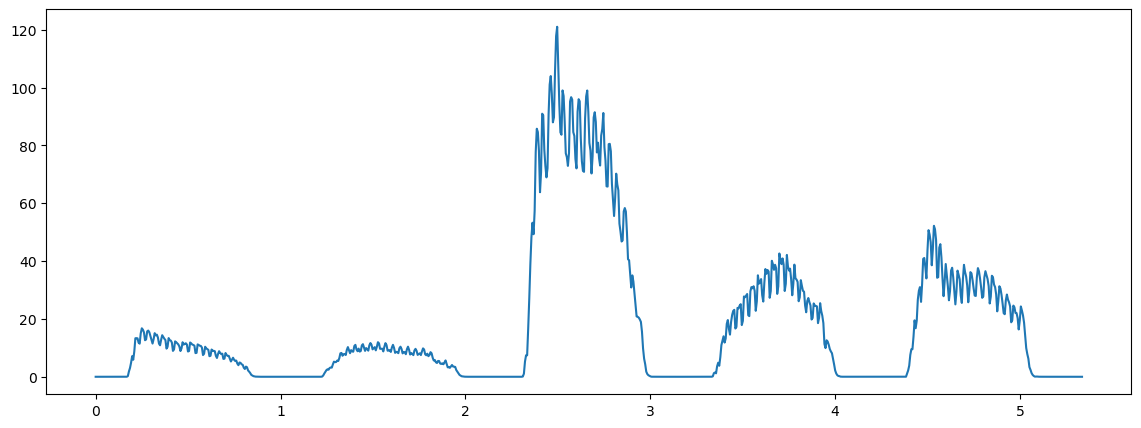

In [8]:
hop_length = 256
frame_length = 512
energy = np.array([
    sum(abs(sample_x[i:i+frame_length]**2))
    for i in range(0, len(sample_x), hop_length)
])
frames = range(len(energy))
t = librosa.frames_to_time(frames, sr=sampling_rate, hop_length=hop_length)
plt.figure(figsize=(14, 5))
plt.plot(t, energy)
plt.show()

In [9]:
rmse = librosa.feature.rms(sample_x, frame_length=frame_length, hop_length=hop_length, center=True)[0]

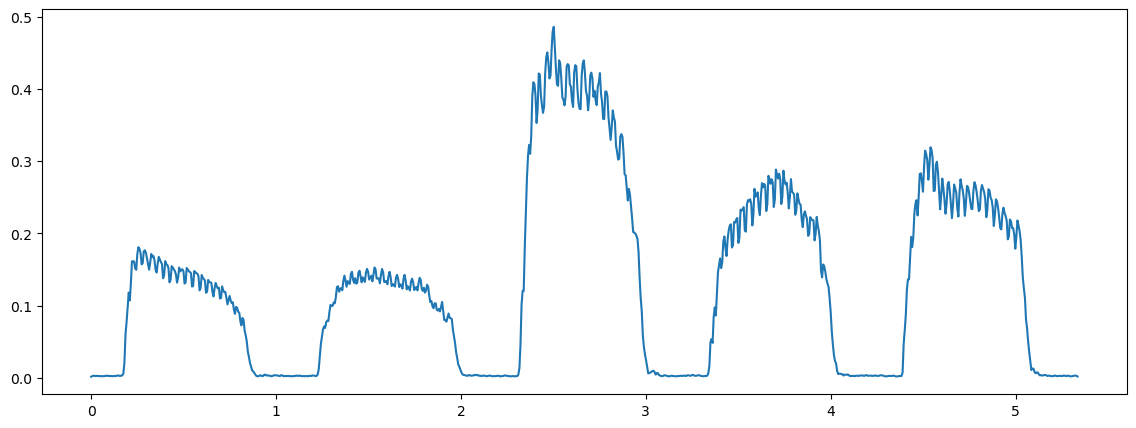

In [10]:
plt.figure(figsize=(14, 5))
plt.plot(t, rmse)
plt.show()

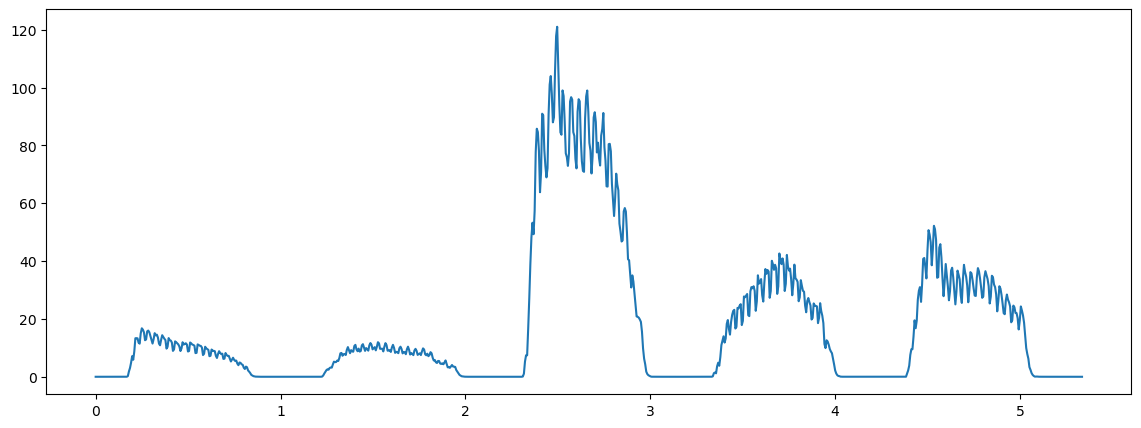

In [11]:
plt.figure(figsize=(14, 5))
plt.plot(t, energy)
plt.show()

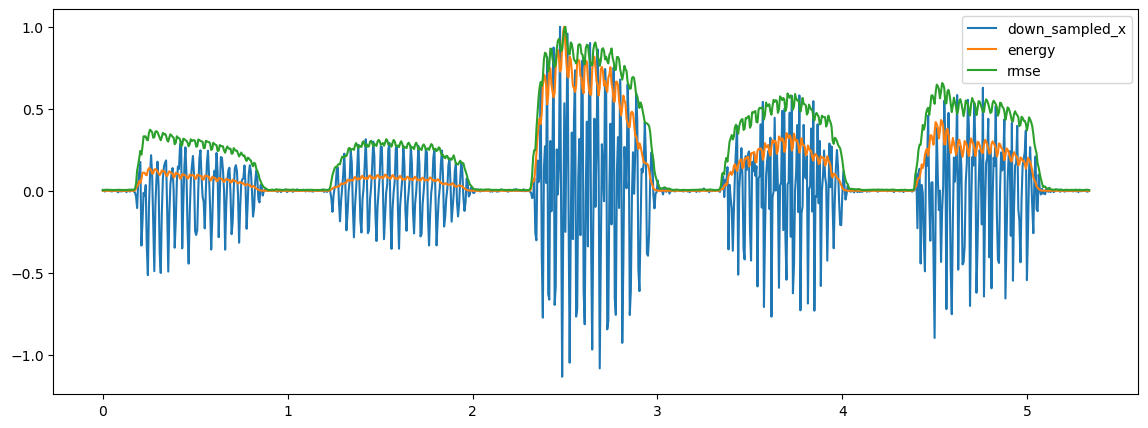

In [12]:
down_sampled_x = np.array([
    sample_x[i] for i in range(0, len(sample_x), hop_length)
])
plt.figure(figsize=(14, 5))
plt.plot(t, down_sampled_x/np.max(down_sampled_x), label='down_sampled_x')
plt.plot(t, energy/np.max(energy), label='energy')
plt.plot(t, rmse/np.max(rmse), label='rmse')
plt.legend()
plt.show()

### 音高

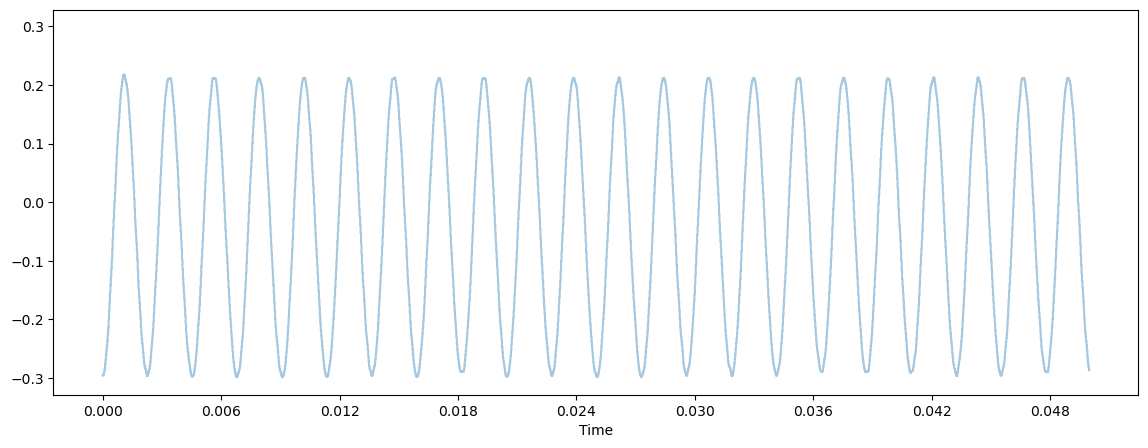

In [32]:
audio_file = "./data/example/tuningFork01.wav"
plt.figure(figsize=(14, 5))
sample, sampling_rate = librosa.load(audio_file, sr=44100)
sample_s = sample[int(0.5*sampling_rate):int(0.55*sampling_rate)]
librosa.display.waveshow(sample_s, sr=sampling_rate, alpha=0.4)
plt.show()
IPython.display.Audio(audio_file)



In [14]:
from scipy.signal import butter, filtfilt
import numpy as np
cutoff = 768
order = 6
nyq = 0.5 * sampling_rate
normal_cutoff = cutoff / nyq
b, a = butter(order, normal_cutoff, btype='high', analog=False)
conditioned_signal  = filtfilt(b, a, sample_x)

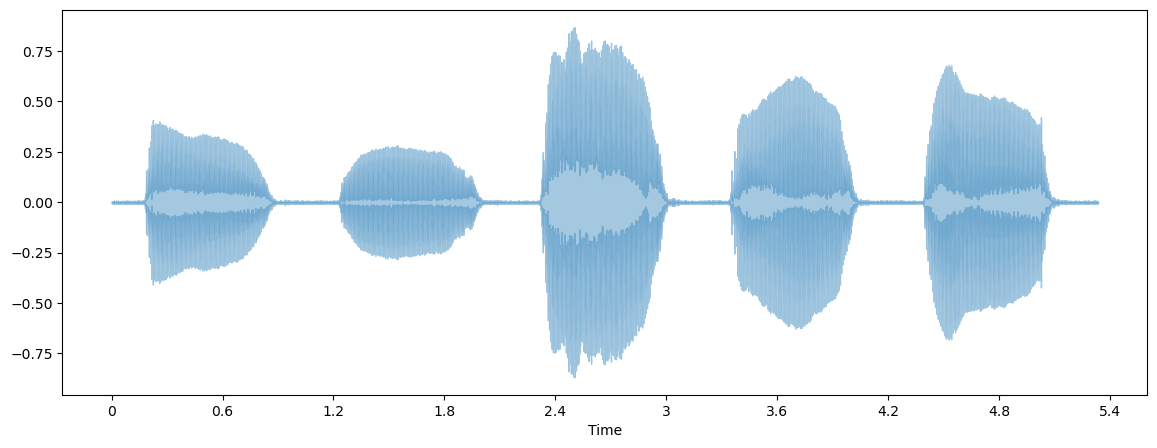

In [15]:
plt.figure(figsize=(14, 5))
librosa.display.waveshow(sample_x, sr=sampling_rate, alpha=0.4)
plt.show()

In [16]:
from IPython.display import Audio
Audio(data=sample_x, rate=sampling_rate)

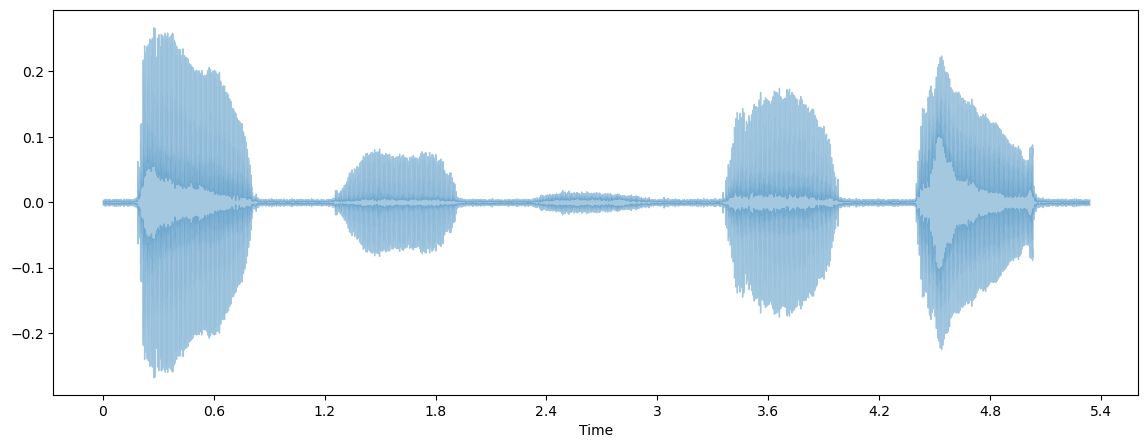

In [17]:
plt.figure(figsize=(14, 5))
librosa.display.waveshow(conditioned_signal, sr=sampling_rate, alpha=0.4)
plt.show()

In [18]:
Audio(data=conditioned_signal, rate=sampling_rate)

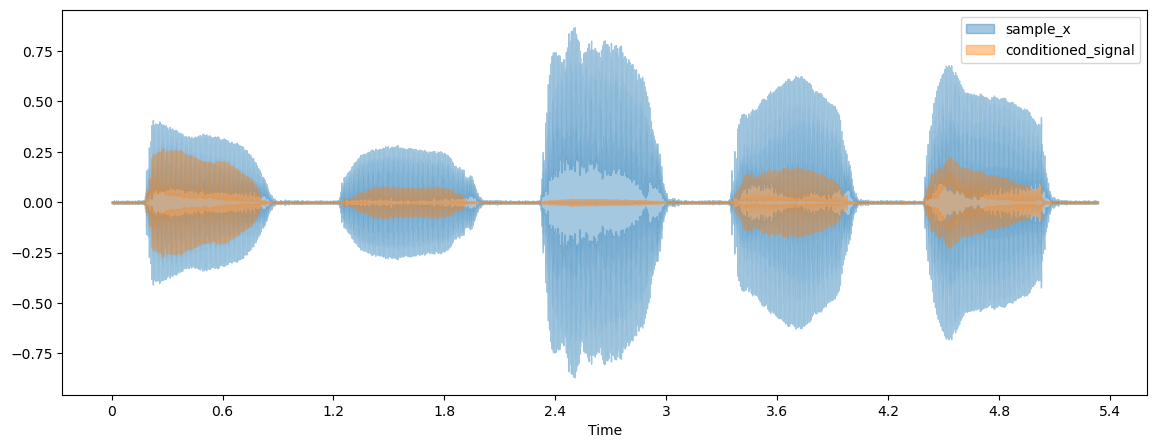

In [19]:
plt.figure(figsize=(14, 5))
librosa.display.waveshow(sample_x, sr=sampling_rate, alpha=0.4, label='sample_x')
librosa.display.waveshow(conditioned_signal, sr=sampling_rate, alpha=0.4, label='conditioned_signal')
plt.legend()
plt.show()

### 过零率

In [20]:
# zero_crossings
zero_crossings = librosa.zero_crossings(sample_s, pad=False)
print(sum(zero_crossings))

44


### 频谱质心(spectral centroids)

In [21]:
#spectral centroid -- centre of mass -- weighted mean of the frequencies present in the sound
spectral_centroids = librosa.feature.spectral_centroid(sample_x, sr=sampling_rate)[0]
spectral_centroids.shape

(460,)

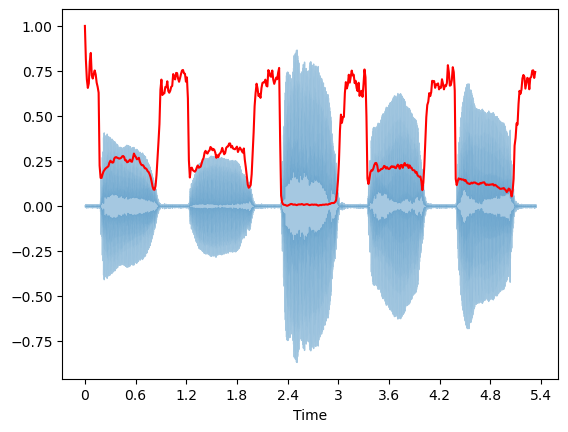

In [22]:
# Computing the time variable for visualization
frames = range(len(spectral_centroids))
t = librosa.frames_to_time(frames, sr=sampling_rate)
# Normalising the spectral centroid for visualisation
def normalize(x, axis=0):
    return sklearn.preprocessing.minmax_scale(x, axis=axis)

# Plotting the Spectral Centroid along the waveform
librosa.display.waveshow(sample_x, sr=sampling_rate, alpha=0.4)
plt.plot(t, normalize(spectral_centroids), color='r')

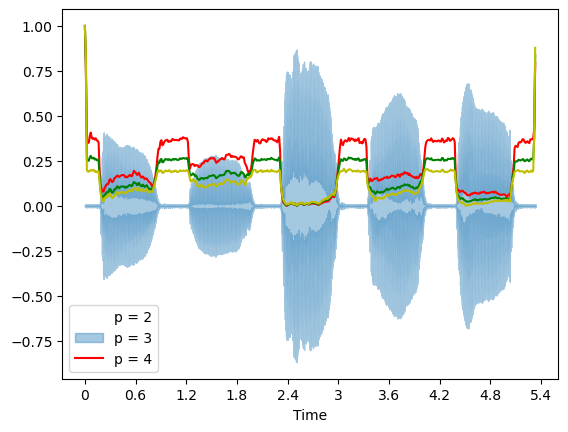

In [23]:
spectral_bandwidth_2 = librosa.feature.spectral_bandwidth(sample_x+0.01, sr=sampling_rate)[0]
spectral_bandwidth_3 = librosa.feature.spectral_bandwidth(sample_x+0.01, sr=sampling_rate, p=3)[0]
spectral_bandwidth_4 = librosa.feature.spectral_bandwidth(sample_x+0.01, sr=sampling_rate, p=4)[0]
librosa.display.waveshow(sample_x, sr=sampling_rate, alpha=0.4)
plt.plot(t, normalize(spectral_bandwidth_2), color='r')
plt.plot(t, normalize(spectral_bandwidth_3), color='g')
plt.plot(t, normalize(spectral_bandwidth_4), color='y')
plt.legend(('p = 2', 'p = 3', 'p = 4'))

### 频谱截止频谱（spectral roll off frequency，SRF）

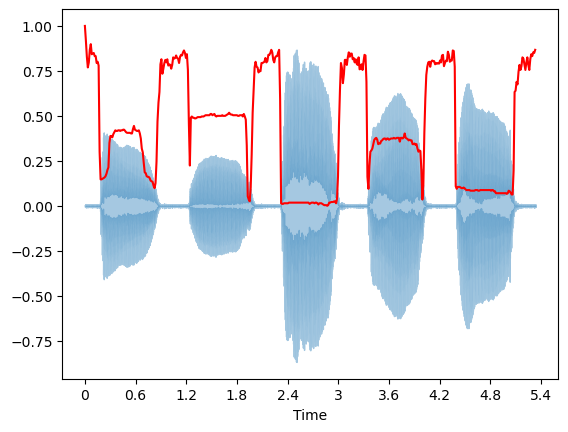

In [24]:
# Spectral Rolloff
spectral_rolloff = librosa.feature.spectral_rolloff(sample_x, sr=sampling_rate)[0]
librosa.display.waveshow(sample_x, sr=sampling_rate, alpha=0.4)
plt.plot(t, normalize(spectral_rolloff), color='r')

Text(0.5, 0, 'Frequency (Hz)')

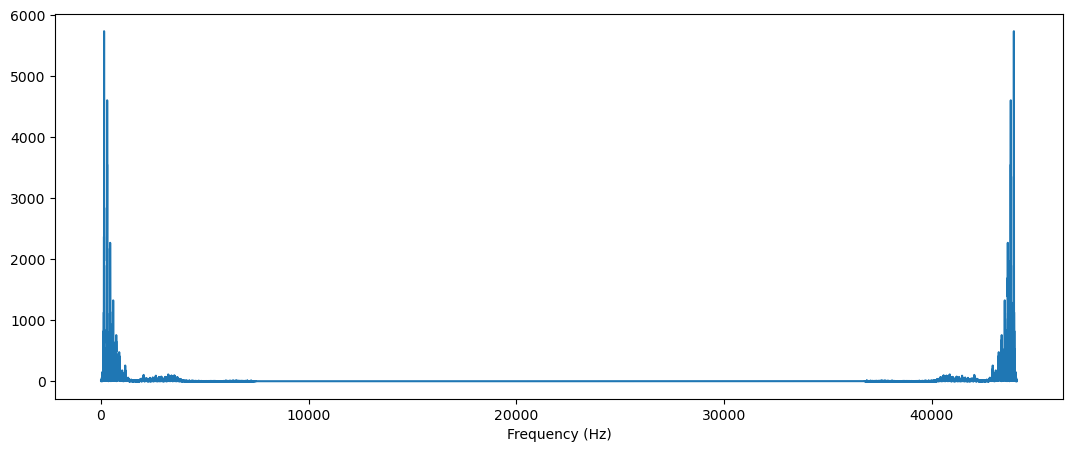

In [26]:
from scipy.fft import fft, ifft
fft_result = fft(sample_x)
fft_abs = np.absolute(fft_result)
f = np.linspace(0, sampling_rate, len(fft_abs)) # frequency variable
plt.figure(figsize=(13, 5))
plt.plot(f, fft_abs) # magnitude spectrum
plt.xlabel('Frequency (Hz)')

Text(0.5, 0, 'Frequency (Hz)')

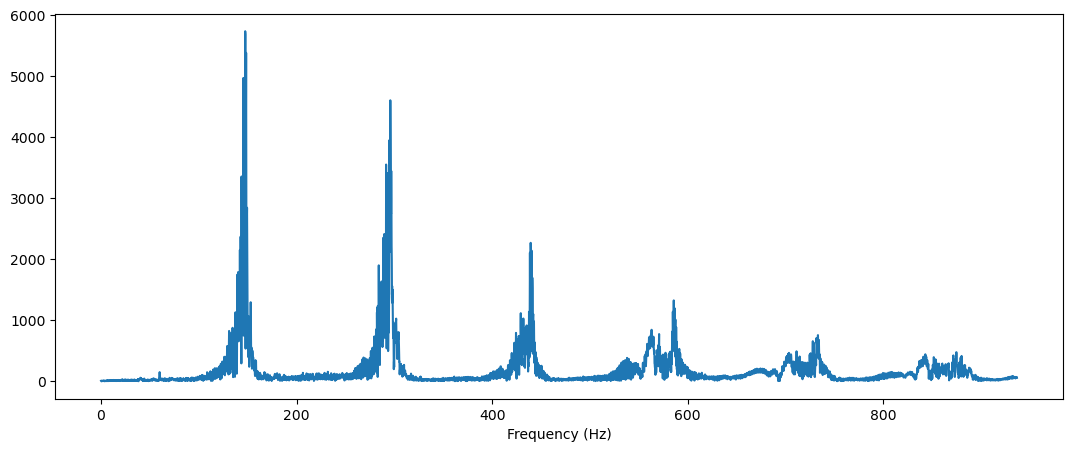

In [27]:
plt.figure(figsize=(13, 5))
plt.plot(f[:5000], fft_abs[:5000])
plt.xlabel('Frequency (Hz)')

頻譜(Short-Time Fourier Transform)

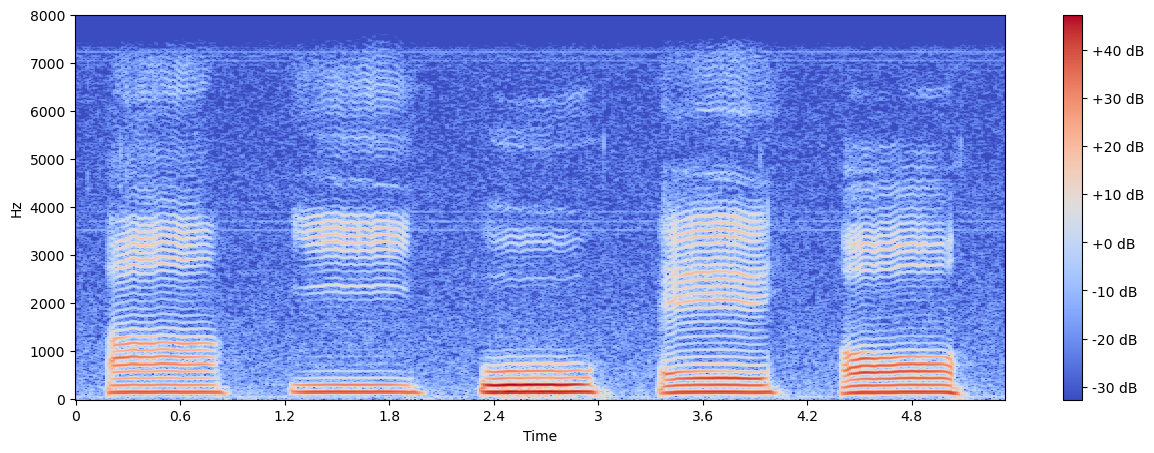

In [31]:
hop_length = 512
n_fft = 2048
sample_stft = librosa.stft(sample_x, n_fft=n_fft, hop_length=hop_length)
sample_stft_db = librosa.amplitude_to_db(abs(sample_stft))
plt.figure(figsize=(15, 5))
librosa.display.specshow(sample_stft_db, sr=sampling_rate, hop_length=hop_length, x_axis='time', y_axis='linear')
plt.ylim(top=8000)
plt.colorbar(format='%+2.0f dB')

### Constant-Q Transform and Chroma

#### Constant-Q Transform

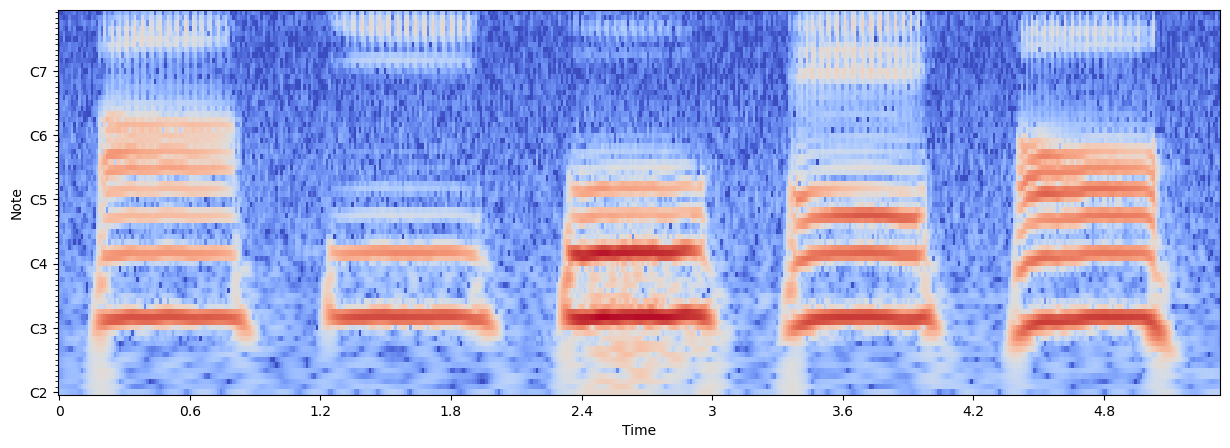

In [ ]:
fmin = librosa.midi_to_hz(36)
hop_length = 512
C = librosa.cqt(sample_x, sr=sampling_rate, fmin=fmin, n_bins=72, hop_length=hop_length)
logC = librosa.amplitude_to_db(numpy.abs(C))
plt.figure(figsize=(15, 5))
librosa.display.specshow(logC, sr=sampling_rate, x_axis='time', y_axis='cqt_note', fmin=fmin, cmap='coolwarm')

### Chroma

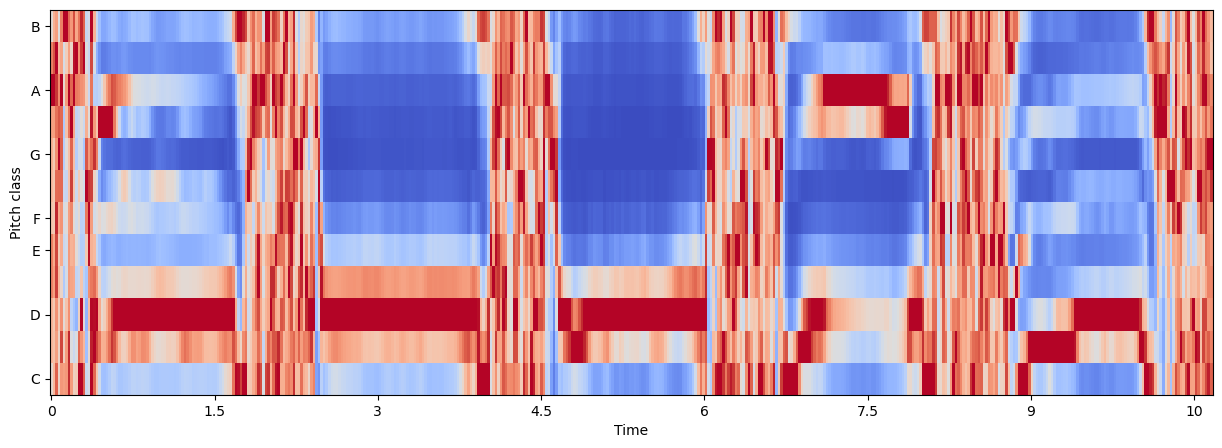

In [ ]:
chromagram = librosa.feature.chroma_stft(sample_x, sr=sampling_rate, hop_length=hop_length)
plt.figure(figsize=(15, 5))
librosa.display.specshow(chromagram, x_axis='time', y_axis='chroma', hop_length=hop_length, cmap='coolwarm')

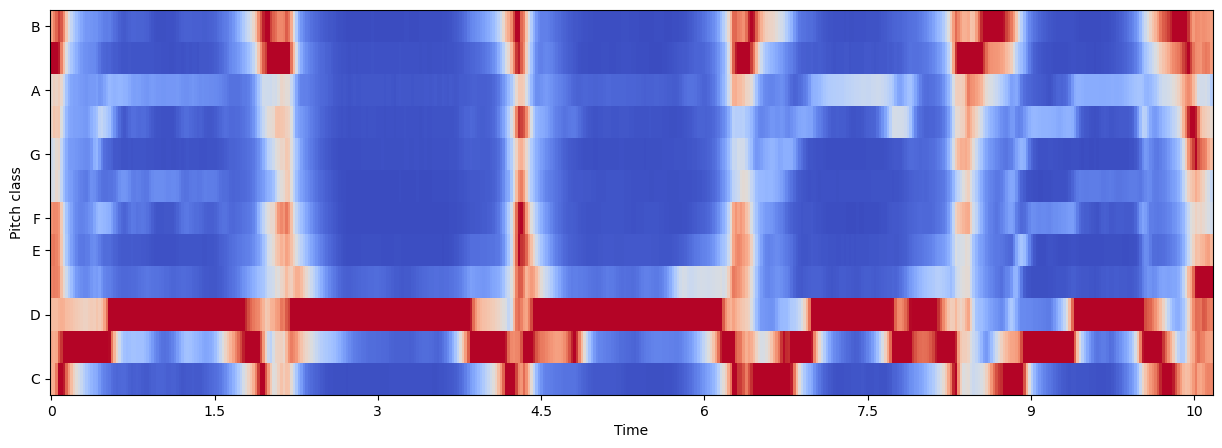

In [ ]:
chromagram = librosa.feature.chroma_cqt(sample_x, sr=sampling_rate, hop_length=hop_length)
plt.figure(figsize=(15, 5))
librosa.display.specshow(chromagram, x_axis='time', y_axis='chroma', hop_length=hop_length, cmap='coolwarm')

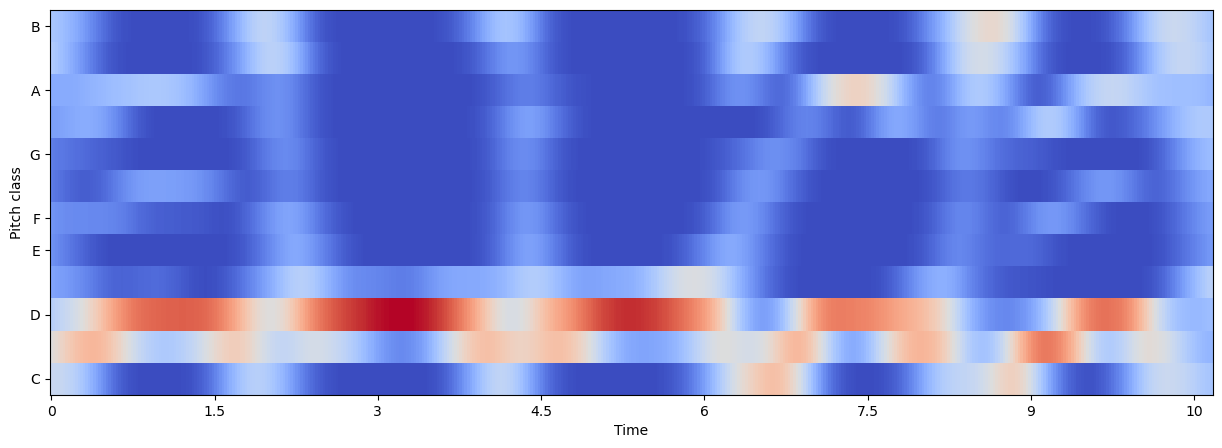

In [ ]:
chromagram = librosa.feature.chroma_cens(sample_x, sr=sampling_rate, hop_length=hop_length)
plt.figure(figsize=(15, 5))
librosa.display.specshow(chromagram, x_axis='time', y_axis='chroma', hop_length=hop_length, cmap='coolwarm')


### 载入RAVDESS

RAVDESS 包含 1440 个文件：每个演员 60 次试验 x 24 名演员 = 1440。
RAVDESS 包含 24 名专业演员（12 名女性，12 名男性），用中性的北美口音说出两个词汇匹配的陈述。言语情绪包括平静、快乐、悲伤、愤怒、恐惧、惊讶和厌恶的表情。每种表情都在两种情绪强度（正常、强烈）和一种额外的中性表情下产生。

1440 个文件中的每一个都有一个唯一的文件名。文件名由 7 部分数字标识符组成（例如，03-01-06-01-02-01-12.wav）。这些标识符定义了刺激特征：

文件名标识符
- 模态（01 = 全 AV，02 = 仅视频，03 = 仅音频）。
- 人声通道（01 = 语音，02 = 歌曲）。
- 情绪（01 = 中性，02 = 平静，03 = 快乐，04 = 悲伤，05 = 愤怒，06 = 恐惧，07 = 厌恶，08 = 惊讶）。
- 情绪强度（01 = 正常，02 = 强烈）。注意：“中性”情绪没有强烈的强度。
- 声明（01 =“Kids are talking by the door”，02 =“Dogs are sitting by the door”）。
- 重复（01 = 第一次重复，02 = 第二次重复）。
- 演员（01 到 24。奇数为男性，偶数为女性）。

In [35]:
audio_neutral = "./data/RAVDESS/Actor_03/03-01-01-01-01-01-03.wav"
audio_happy = "./data/RAVDESS/Actor_03/03-01-03-01-01-01-03.wav"
audio_fear = "./data/RAVDESS/Actor_03/03-01-06-01-01-01-03.wav"
audio2_neutral = "./data/RAVDESS/Actor_03/03-01-01-01-02-01-03.wav"
# Kids are talking by the door, 中性
IPython.display.Audio(audio_neutral)

In [36]:
# Kids are talking by the door, 快乐
IPython.display.Audio(audio_happy)

In [37]:
# Kids are talking by the door, 恐惧
IPython.display.Audio(audio_fear)

In [38]:
# Dogs are sitting by the door, 中性
IPython.display.Audio(audio2_neutral)

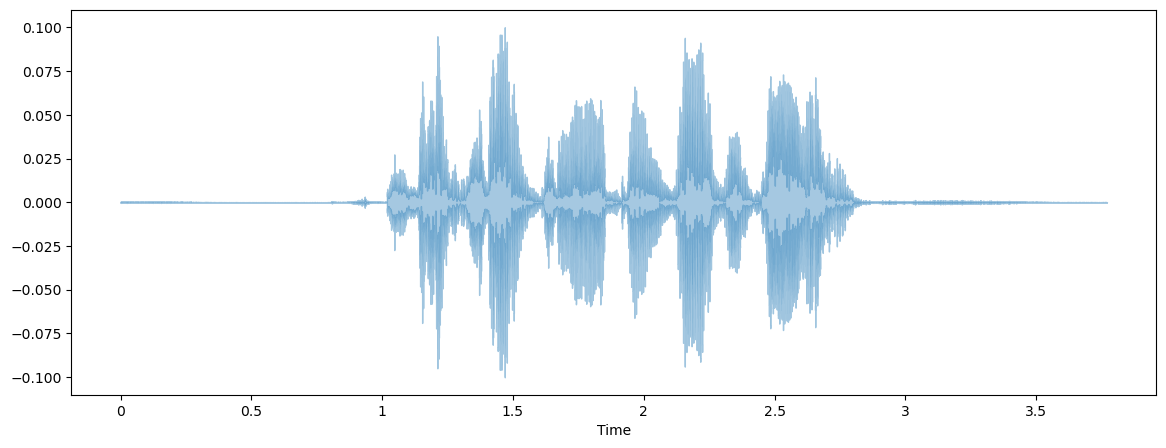

In [39]:
plt.figure(figsize=(14, 5))
sample_x, sampling_rate = librosa.load(audio_happy, sr=44100)
librosa.display.waveshow(sample_x, sr=sampling_rate, alpha=0.4)

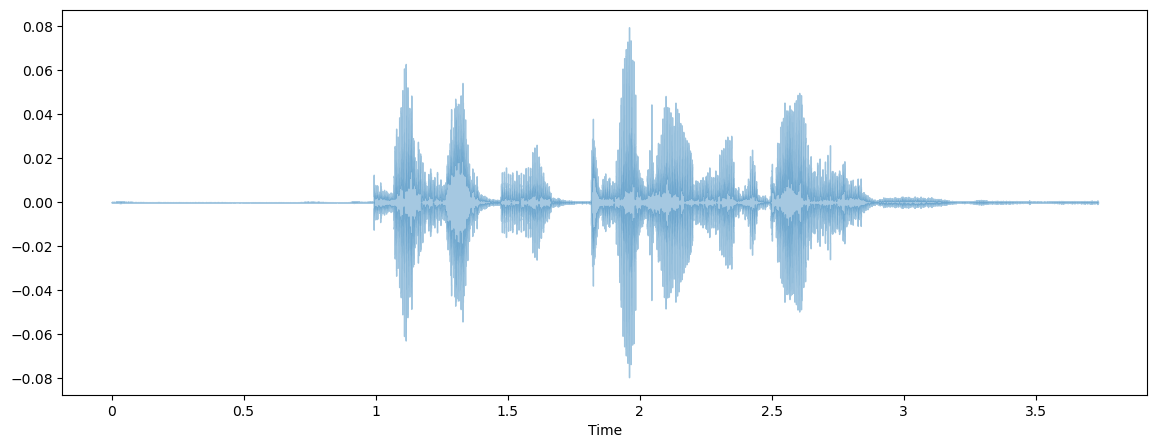

In [40]:
plt.figure(figsize=(14, 5))
sample_x, sampling_rate = librosa.load(audio_fear, sr=44100)
librosa.display.waveshow(sample_x, sr=sampling_rate, alpha=0.4)

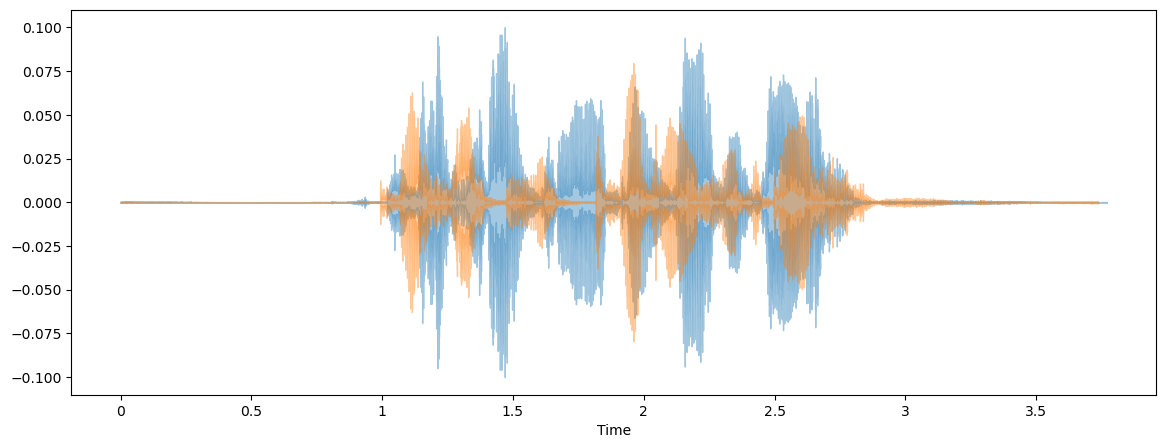

In [41]:
plt.figure(figsize=(14, 5))
sample_x, sampling_rate = librosa.load(audio_happy, sr=44100)
librosa.display.waveshow(sample_x, sr=sampling_rate, alpha=0.4)
sample_x, sampling_rate = librosa.load(audio_fear, sr=44100)
librosa.display.waveshow(sample_x, sr=sampling_rate, alpha=0.4)

### Spectrogram

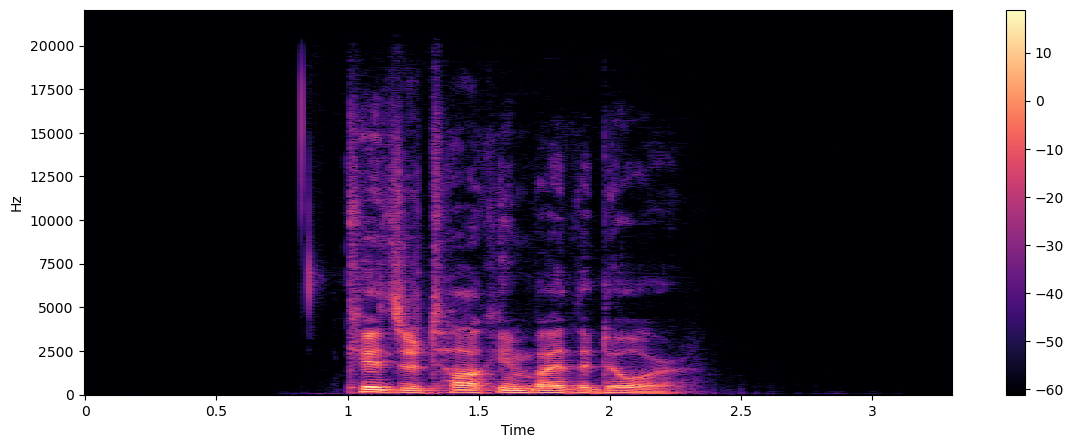

In [9]:
stft_x = librosa.stft(sample_x)
Xdb = librosa.amplitude_to_db(abs(stft_x))
plt.figure(figsize=(14, 5))
librosa.display.specshow(Xdb, sr=sampling_rate, x_axis='time', y_axis='hz')
plt.colorbar()

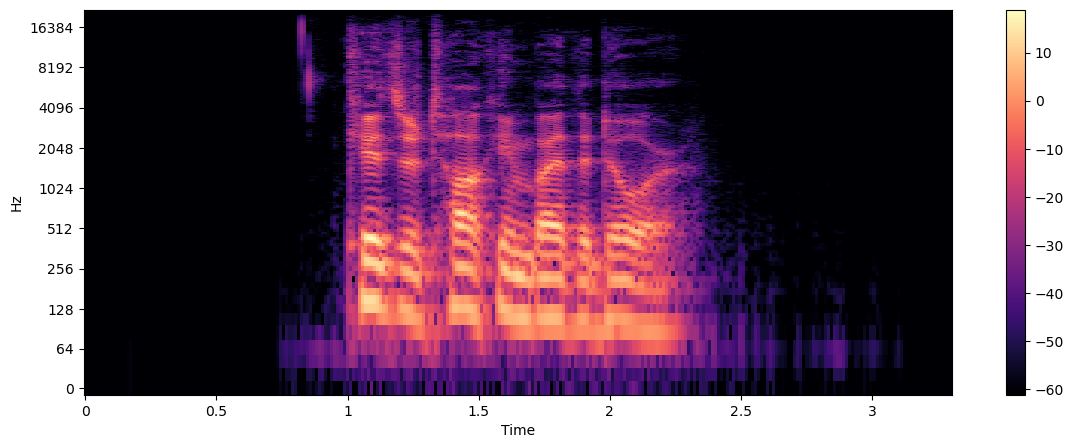

In [10]:
#Log
plt.figure(figsize=(14, 5))
librosa.display.specshow(Xdb, sr=sampling_rate, x_axis='time', y_axis='log')
plt.colorbar()

## 机器学习预测及分类

In [ ]:
audio_files = []
for path, subdirs, files in os.walk("./data/RAVDESS"):
    for name in files:
        audio_files.append(os.path.join(path, name))


# all emotions on RAVDESS dataset
int2emotion = {
    "01": "neutral",
    "02": "calm",
    "03": "happy",
    "04": "sad",
    "05": "angry",
    "06": "fearful",
    "07": "disgust",
    "08": "surprised"
}

# we allow only these emotions
AVAILABLE_EMOTIONS = {
    "angry",
    "sad",
    "neutral",
    "happy"
}

In [9]:
# get the base name of the audio file4
X = []
y = []
file_location_x = './model/saved_audio_file_X.pkl'
file_location_y = './model/saved_audio_file_y.pkl'
if os.path.isfile(file_location_x):
    with open(file_location_x, 'rb') as handle:
        X = pickle.load(handle)
    with open(file_location_y, 'rb') as handle:
        y = pickle.load(handle)
else:
    for file in audio_files:
        basename = os.path.basename(file)
        # get the emotion label
        emotion = int2emotion[basename.split("-")[2]]
        audio_time_series , sample_rate = librosa.load(file) #audio time series
        stft = np.abs(librosa.stft(audio_time_series))    
        result = np.array([])
        #40個特徵
        mfccs = np.mean(librosa.feature.mfcc(y=audio_time_series, sr=sample_rate, n_mfcc=40).T, axis=0)
        result = np.hstack((result, mfccs))
        #12個特徵
        chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)
        result = np.hstack((result, chroma))
        #128個特徵
        mel = np.mean(librosa.feature.melspectrogram(y=audio_time_series, sr=sample_rate).T,axis=0)
        result = np.hstack((result, mel))
        #7個特徵
        contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sample_rate).T,axis=0)
        result = np.hstack((result, contrast))
        #6個特徵
        tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(audio_time_series), sr=sample_rate).T,axis=0)
        result = np.hstack((result, tonnetz))

        # add to data
        X.append(result)
        y.append(emotion)
    with open(file_location_x, 'wb') as handle:
        pickle.dump(X, handle, protocol=pickle.HIGHEST_PROTOCOL)
    with open(file_location_y, 'wb') as handle:
        pickle.dump(y, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [10]:
X_train, X_test, y_train, y_test = train_test_split(np.array(X), y, test_size=0.2, random_state=7)

In [11]:
dtree_model = DecisionTreeClassifier(max_depth = 2).fit(X_train, y_train) 
dtree_predictions = dtree_model.predict(X_test) 
print(accuracy_score(y_true=y_test,y_pred=dtree_predictions))
print(classification_report(y_test,dtree_predictions)) 
print(confusion_matrix(y_test, dtree_predictions) )

0.3125
              precision    recall  f1-score   support

       angry       0.63      0.53      0.58        32
        calm       0.41      0.87      0.56        38
     disgust       0.00      0.00      0.00        44
     fearful       0.00      0.00      0.00        29
       happy       0.00      0.00      0.00        40
     neutral       0.00      0.00      0.00        20
         sad       0.22      0.24      0.23        42
   surprised       0.22      0.70      0.34        43

    accuracy                           0.31       288
   macro avg       0.19      0.29      0.21       288
weighted avg       0.19      0.31      0.22       288

[[17  0  0  0  0  0  0 15]
 [ 0 33  0  0  0  0  3  2]
 [ 1 10  0  0  0  0  9 24]
 [ 3  1  0  0  0  0  8 17]
 [ 6  6  0  0  0  0  4 24]
 [ 0 14  0  0  0  0  4  2]
 [ 0 10  0  0  0  0 10 22]
 [ 0  6  0  0  0  0  7 30]]


In [12]:
dtree_model = DecisionTreeClassifier(max_depth = 6).fit(X_train, y_train) 
dtree_predictions = dtree_model.predict(X_test) 
print(accuracy_score(y_true=y_test,y_pred=dtree_predictions))
print(classification_report(y_test,dtree_predictions)) 
print(confusion_matrix(y_test, dtree_predictions) )

0.3784722222222222
              precision    recall  f1-score   support

       angry       0.60      0.47      0.53        32
        calm       0.45      0.58      0.51        38
     disgust       0.28      0.50      0.36        44
     fearful       0.44      0.48      0.46        29
       happy       0.34      0.25      0.29        40
     neutral       0.19      0.15      0.17        20
         sad       0.31      0.19      0.24        42
   surprised       0.45      0.35      0.39        43

    accuracy                           0.38       288
   macro avg       0.38      0.37      0.37       288
weighted avg       0.39      0.38      0.37       288

[[15  0  8  4  3  0  0  2]
 [ 0 22  5  0  0  4  6  1]
 [ 0  4 22  1  4  3  5  5]
 [ 3  2  7 14  1  2  0  0]
 [ 4  4  8  5 10  1  3  5]
 [ 0 10  4  0  1  3  1  1]
 [ 0  5 10  6  7  2  8  4]
 [ 3  2 14  2  3  1  3 15]]


### Random Forest

In [13]:
classifier = RandomForestClassifier(n_estimators = 20,random_state = 0) 
classifier.fit(X_train, y_train)   
c_p = classifier.predict(X_test) 
print(accuracy_score(y_true=y_test,y_pred=c_p))
print(classification_report(y_test,c_p)) 
print(confusion_matrix(y_test,c_p) )

0.4895833333333333
              precision    recall  f1-score   support

       angry       0.61      0.62      0.62        32
        calm       0.46      0.63      0.53        38
     disgust       0.49      0.57      0.53        44
     fearful       0.41      0.59      0.49        29
       happy       0.45      0.35      0.39        40
     neutral       0.42      0.25      0.31        20
         sad       0.43      0.38      0.41        42
   surprised       0.65      0.47      0.54        43

    accuracy                           0.49       288
   macro avg       0.49      0.48      0.48       288
weighted avg       0.50      0.49      0.48       288

[[20  0  6  1  1  0  0  4]
 [ 1 24  0  2  1  3  7  0]
 [ 3  6 25  1  4  0  5  0]
 [ 2  2  4 17  1  1  1  1]
 [ 6  4  2  9 14  1  2  2]
 [ 0 10  1  0  0  5  3  1]
 [ 0  4  3  7  7  2 16  3]
 [ 1  2 10  4  3  0  3 20]]


In [14]:
classifier = RandomForestClassifier(n_estimators = 100, random_state = 0) 
classifier.fit(X_train, y_train)  
c_p = classifier.predict(X_test) 
print(accuracy_score(y_true=y_test,y_pred=c_p))
print(classification_report(y_test,c_p)) 
print(confusion_matrix(y_test,c_p) )


0.5520833333333334
              precision    recall  f1-score   support

       angry       0.77      0.62      0.69        32
        calm       0.49      0.74      0.59        38
     disgust       0.56      0.55      0.55        44
     fearful       0.42      0.62      0.50        29
       happy       0.57      0.42      0.49        40
     neutral       0.73      0.40      0.52        20
         sad       0.48      0.48      0.48        42
   surprised       0.67      0.56      0.61        43

    accuracy                           0.55       288
   macro avg       0.58      0.55      0.55       288
weighted avg       0.58      0.55      0.55       288

[[20  0  5  1  1  0  0  5]
 [ 0 28  0  4  0  2  4  0]
 [ 1 10 24  2  3  0  4  0]
 [ 1  2  2 18  0  1  3  2]
 [ 2  4  3  7 17  0  4  3]
 [ 0  7  0  0  1  8  4  0]
 [ 0  4  2  9  5  0 20  2]
 [ 2  2  7  2  3  0  3 24]]


### SVM

In [15]:
svm_model_linear = SVC().fit(X_train, y_train) 
svm_predictions = svm_model_linear.predict(X_test) 
print(accuracy_score(y_true=y_test,y_pred=svm_predictions))
print(classification_report(y_test,svm_predictions)) 
print(confusion_matrix(y_test, svm_predictions) )

0.3020833333333333
              precision    recall  f1-score   support

       angry       0.38      0.62      0.48        32
        calm       0.30      0.82      0.43        38
     disgust       0.31      0.25      0.28        44
     fearful       0.27      0.14      0.18        29
       happy       0.23      0.17      0.20        40
     neutral       0.00      0.00      0.00        20
         sad       0.20      0.05      0.08        42
   surprised       0.30      0.28      0.29        43

    accuracy                           0.30       288
   macro avg       0.25      0.29      0.24       288
weighted avg       0.26      0.30      0.25       288

[[20  1  2  0  2  0  0  7]
 [ 0 31  0  0  4  0  3  0]
 [ 3 13 11  3  5  0  1  8]
 [11  7  2  4  0  0  0  5]
 [13  8  4  1  7  0  3  4]
 [ 0 17  2  0  0  0  1  0]
 [ 2 15  8  5  6  0  2  4]
 [ 3 13  6  2  7  0  0 12]]


In [16]:
svm_model_linear = SVC(kernel = 'linear', C = 1).fit(X_train, y_train) 
svm_predictions = svm_model_linear.predict(X_test) 
print(accuracy_score(y_true=y_test,y_pred=svm_predictions))
print(classification_report(y_test,svm_predictions)) 
# creating a confusion matrix 
print(confusion_matrix(y_test, svm_predictions) )
print(svm_model_linear.score(X_test, y_test))

0.5486111111111112
              precision    recall  f1-score   support

       angry       0.65      0.75      0.70        32
        calm       0.55      0.63      0.59        38
     disgust       0.52      0.52      0.52        44
     fearful       0.41      0.55      0.47        29
       happy       0.66      0.53      0.58        40
     neutral       0.44      0.35      0.39        20
         sad       0.44      0.38      0.41        42
   surprised       0.68      0.63      0.65        43

    accuracy                           0.55       288
   macro avg       0.54      0.54      0.54       288
weighted avg       0.55      0.55      0.55       288

[[24  0  1  3  3  0  1  0]
 [ 1 24  3  1  0  4  5  0]
 [ 4  7 23  0  4  0  3  3]
 [ 4  1  3 16  2  0  1  2]
 [ 4  1  4  6 21  1  2  1]
 [ 0  7  0  0  0  7  2  4]
 [ 0  4  2 11  2  4 16  3]
 [ 0  0  8  2  0  0  6 27]]
0.5486111111111112


### MLP

In [17]:
# best model, determined by a grid search
model_params = {
    'alpha': 0.01,
    'batch_size': 256,
    'epsilon': 1e-08, 
    'hidden_layer_sizes': (300,), 
    'learning_rate': 'adaptive', 
    'max_iter': 500, 
}
# initialize Multi Layer Perceptron classifier
# with best parameters ( so far )
model = MLPClassifier(**model_params)

# train the model
print("[*] Training the model...")
model.fit(X_train, y_train)

# predict 25% of data to measure how good we are
y_pred = model.predict(X_test)

# calculate the accuracy
accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)
print("Accuracy: {:.2f}%".format(accuracy*100))
print(classification_report(y_test,y_pred))
print(confusion_matrix(y_test,y_pred))

[*] Training the model...
Accuracy: 54.51%
              precision    recall  f1-score   support

       angry       0.85      0.72      0.78        32
        calm       0.44      0.50      0.47        38
     disgust       0.80      0.36      0.50        44
     fearful       0.44      0.69      0.54        29
       happy       0.59      0.80      0.68        40
     neutral       0.40      0.10      0.16        20
         sad       0.33      0.45      0.38        42
   surprised       0.70      0.60      0.65        43

    accuracy                           0.55       288
   macro avg       0.57      0.53      0.52       288
weighted avg       0.58      0.55      0.54       288

[[23  0  0  3  3  0  1  2]
 [ 0 19  0  4  2  2 11  0]
 [ 3  9 16  3  5  1  4  3]
 [ 1  1  0 20  3  0  4  0]
 [ 0  0  1  1 32  0  5  1]
 [ 0  7  0  1  0  2  8  2]
 [ 0  7  0 11  2  0 19  3]
 [ 0  0  3  2  7  0  5 26]]


In [36]:
mn_params = {
    'alpha': 0.01,
    'batch_size': 256,
    'epsilon': 1e-08, 
    'hidden_layer_sizes': (300, 300), 
    'learning_rate': 'adaptive', 
    'max_iter': 500, 
}
# initialize Multi Layer Perceptron classifier
# with best parameters ( so far )
m2 = MLPClassifier(**mn_params)

# train the model
print("[*] Training the model...")
m2.fit(X_train, y_train)

# predict 25% of data to measure how good we are
y_p2 = m2.predict(X_test)

# calculate the accuracy
accuracy = accuracy_score(y_true=y_test, y_pred=y_p2)
print("Accuracy: {:.2f}%".format(accuracy*100))
print(classification_report(y_test,y_p2))
print(confusion_matrix(y_test,y_p2))

[*] Training the model...
Accuracy: 38.19%
              precision    recall  f1-score   support

       angry       0.34      0.81      0.48        32
        calm       0.43      0.32      0.36        38
     disgust       1.00      0.14      0.24        44
     fearful       0.60      0.10      0.18        29
       happy       0.41      0.65      0.50        40
     neutral       0.00      0.00      0.00        20
         sad       0.31      0.69      0.43        42
   surprised       0.57      0.19      0.28        43

    accuracy                           0.38       288
   macro avg       0.46      0.36      0.31       288
weighted avg       0.49      0.38      0.33       288

[[26  0  0  1  2  0  2  1]
 [ 6 12  0  0  4  0 16  0]
 [13  5  6  0  7  0 12  1]
 [ 5  1  0  3 12  0  6  2]
 [ 7  1  0  1 26  0  5  0]
 [ 7  4  0  0  2  0  7  0]
 [ 4  4  0  0  3  0 29  2]
 [ 9  1  0  0  8  0 17  8]]


In [34]:
mn_params = {
    'alpha': 0.01,
    'batch_size': 256,
    'epsilon': 1e-08, 
    'hidden_layer_sizes': (30,), 
    'learning_rate': 'adaptive', 
    'max_iter': 500, 
}
# initialize Multi Layer Perceptron classifier
# with best parameters ( so far )
m3 = MLPClassifier(**mn_params)

# train the model
print("[*] Training the model...")
m3.fit(X_train, y_train)

# predict 25% of data to measure how good we are
y_p3 = m3.predict(X_test)

# calculate the accuracy
accuracy = accuracy_score(y_true=y_test, y_pred=y_p3)
print("Accuracy: {:.2f}%".format(accuracy*100))
print(classification_report(y_test,y_p3))
print(confusion_matrix(y_test,y_p3))

[*] Training the model...
Accuracy: 48.96%
              precision    recall  f1-score   support

       angry       0.74      0.62      0.68        32
        calm       0.39      0.53      0.45        38
     disgust       0.54      0.45      0.49        44
     fearful       0.38      0.59      0.46        29
       happy       0.43      0.57      0.49        40
     neutral       0.33      0.20      0.25        20
         sad       0.46      0.31      0.37        42
   surprised       0.69      0.56      0.62        43

    accuracy                           0.49       288
   macro avg       0.50      0.48      0.48       288
weighted avg       0.51      0.49      0.49       288

[[20  0  1  2  5  0  1  3]
 [ 0 20  4  3  3  3  5  0]
 [ 1 10 20  1  6  4  1  1]
 [ 3  3  0 17  3  1  2  0]
 [ 1  1  2  9 23  0  3  1]
 [ 0  6  3  0  2  4  2  3]
 [ 0  8  2 11  5  0 13  3]
 [ 2  3  5  2  6  0  1 24]]
